# Text Description of Symptoms and Disease Predictions
September 15th 2023

## Contact
**Sangyun (Yun) Thom**

email: sangyun.thom@gmail.com

## Business Problem

Have you ever encountered difficulties getting a diagnosis for series of symptoms you have been experiencing? Have you ever been directed to a wrong hospital department and ended up wasting your time and money? While it can be challenging to get an accurate diagnosis in a very short period of time, these negative experiences can be draining on patients' physical and mental health.

One method that can be helpful in reducing these unpleasant experiences is **accurately classifying** patients' potential diseases based on their initial report of symptoms. This can expedite the process of clinical decision making, and help minimize the time and financial costs of both parties: patients and healthcare providers.

Thus, the current project aims to provide **text-driven** early predictions of disease diagnosis.

## Data Overview

**24 diseases** and **50 symptom descriptions** from patients are retrieved from [Kaggle](https://www.kaggle.com/datasets/niyarrbarman/symptom2disease). Here, we briefly look at the data file and explore the two columns.

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import random
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import operator
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("Symptom2Disease.csv", index_col=0)
df.head()

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


In [3]:
# explore all diseases
df['label'].value_counts()

label
Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia                          50
Common Cold                        50
Fungal infection                   50
Dengue                             50
Impetigo                           50
Chicken pox                        50
Typhoid                            50
diabetes                           50
Name: count, dtype: int64

In [4]:
# sample some random symptom description and its disease label
rand_idx = random.randint(0, 1200)
print(f"{rand_idx} {df.iloc[rand_idx]['label']}: {df.iloc[rand_idx]['text']}")

460 Dimorphic Hemorrhoids: I've been quite constipated lately, and going to the restroom has been excruciatingly uncomfortable. I've also observed blood in my stool, and my anus has been aggravated.


It is notable that the disease labels **do not have an uniform formatting**. Some labels are titlecased, and some are lowercased. It may be beneficial to **feature engineer** so that the label column can have a consistent formatting.

In [5]:
# Make all disease labels titlecased
df['label'] = df['label'].apply(str.title)
df['label'].unique()

array(['Psoriasis', 'Varicose Veins', 'Typhoid', 'Chicken Pox',
       'Impetigo', 'Dengue', 'Fungal Infection', 'Common Cold',
       'Pneumonia', 'Dimorphic Hemorrhoids', 'Arthritis', 'Acne',
       'Bronchial Asthma', 'Hypertension', 'Migraine',
       'Cervical Spondylosis', 'Jaundice', 'Malaria',
       'Urinary Tract Infection', 'Allergy',
       'Gastroesophageal Reflux Disease', 'Drug Reaction',
       'Peptic Ulcer Disease', 'Diabetes'], dtype=object)

As confirmed by all unique variables in the label column, all disease labels have been modified and are now **titlecased**.

## Natural Language Processing

Natural Language Processing (**NLP**) allows human language to be processed and analyzed. NLP can have a critical role in predicting disease labels from text descriptions of symptoms in the current project. First, the corpus would be **pre-processed** so that further analyses can be completed. **Vectorization** would be completed in order to make the format more suitable for **machine learning models**, which would follow next.

### Pre-processing

Initial pre-processing steps must be taken to prepare the raw text form of data for machine learning models. This pre-processing includes tokenization, cleaning, and normalization via lemmatization. Here, a custom function `nlp_preprocessing()` is created to take the corpus and walk through the pre-processing steps.


In [6]:
def nlp_preprocessing(corpus):
    """
    Pre-process the raw text through tokenization, cleaning, and lemmatization.

    Parameter:
        corpus (string): raw text data
    Returns:
        lemmed_corp (list): list of unigram tokens
    """
    # Tokenization
    sw = stopwords.words('english') + ["i've", "i'm"]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)" 
    tokenizer = RegexpTokenizer(pattern)
    tokenized_corp = tokenizer.tokenize(corpus)

    # Cleaning
    lower_corp = [token.lower() for token in tokenized_corp]
    sw_corp = [token for token in lower_corp if token not in sw]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmed_corp = [lemmatizer.lemmatize(token) for token in sw_corp]

    return lemmed_corp

In [7]:
df['processed'] = df['text'].apply(nlp_preprocessing)
df.head()

,label,text,processed
0,Psoriasis,I have been experiencing a skin rash on my arm...,"[experiencing, skin, rash, arm, leg, torso, pa..."
1,Psoriasis,"My skin has been peeling, especially on my kne...","[skin, peeling, especially, knee, elbow, scalp..."
2,Psoriasis,I have been experiencing joint pain in my fing...,"[experiencing, joint, pain, finger, wrist, kne..."
3,Psoriasis,"There is a silver like dusting on my skin, esp...","[silver, like, dusting, skin, especially, lowe..."
4,Psoriasis,"My nails have small dents or pits in them, and...","[nail, small, dent, pit, often, feel, inflamma..."


### Explore each disease

Now that the raw text data have been pre-processed into normalized unigrams, symptom descriptions are explored. For this section, **psoriasis** and **arthiritus** are chosen as random example disease to explore. A custon function is created to display a frequency distribution graph for each token in the specific disease and a wordcloud image to visualize frequencies of each word use.

In [8]:
def explore_symptoms(df, disease, n):
    """
    Create frequency distribution plot and wordcloud image to visualize 
    frequencies of each word used in the text description. The dataframe, 
    disease, and number of tokens to visualize can be specified.

    Parameter:
        df (pandas.DataFrame): dataframe with the disease label and list of tokens
        disease (string): disease label
        n (int): number of tokens to display
    Returns:
        matplotlib frequency distribution plot
        matplotlib wordcloud
    """
    # Extract rows with specified disease label from the dataframe
    df_disease = df[df['label'] == disease]

    # Extract the lists of tokens
    disease_symp = []
    for index, row in df_disease.iterrows():
        disease_symp += row['processed']

    # Display frequenty distribution plot
    fdist = FreqDist(disease_symp)
    plt.figure(figsize=(10, 10))
    fdist.plot(n, title=f"{disease} Frequency Distribution of {n} Most Common Words")

    # Display wordcloud
    wordcloud = WordCloud().generate(' '.join(disease_symp))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Example 1: Psoriasis

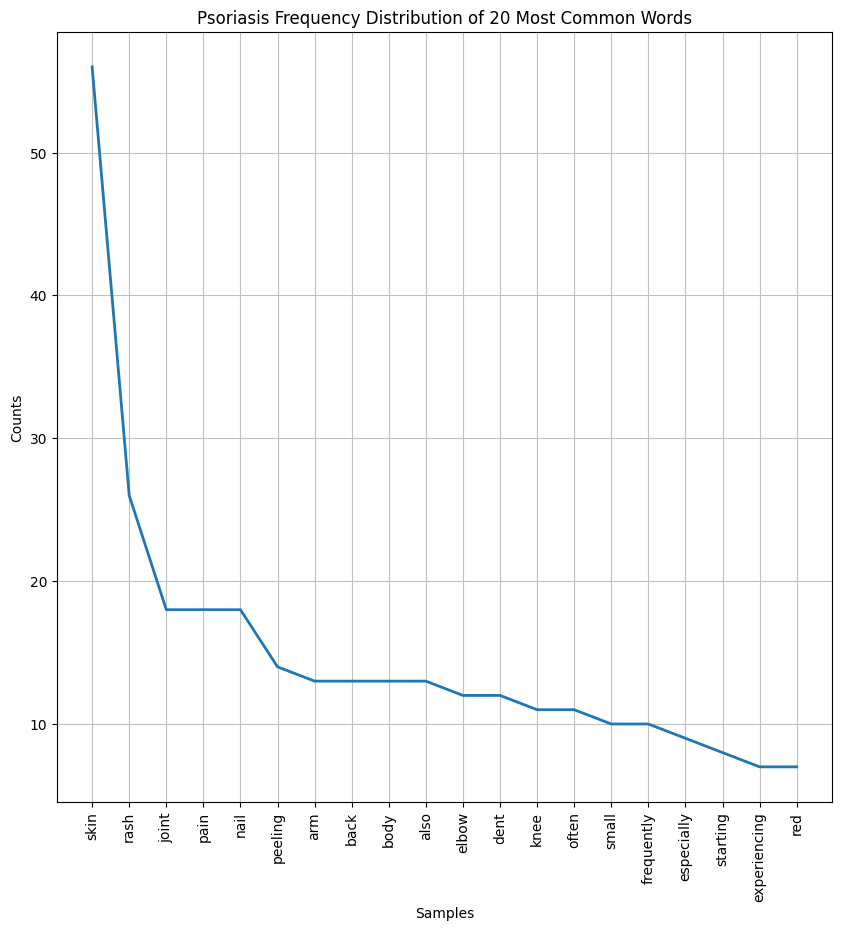

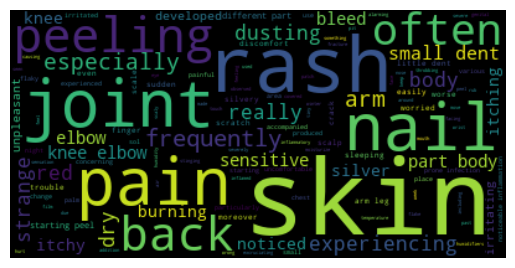

In [9]:
explore_symptoms(df, 'Psoriasis', 20)

##### Example 2: Arthritis

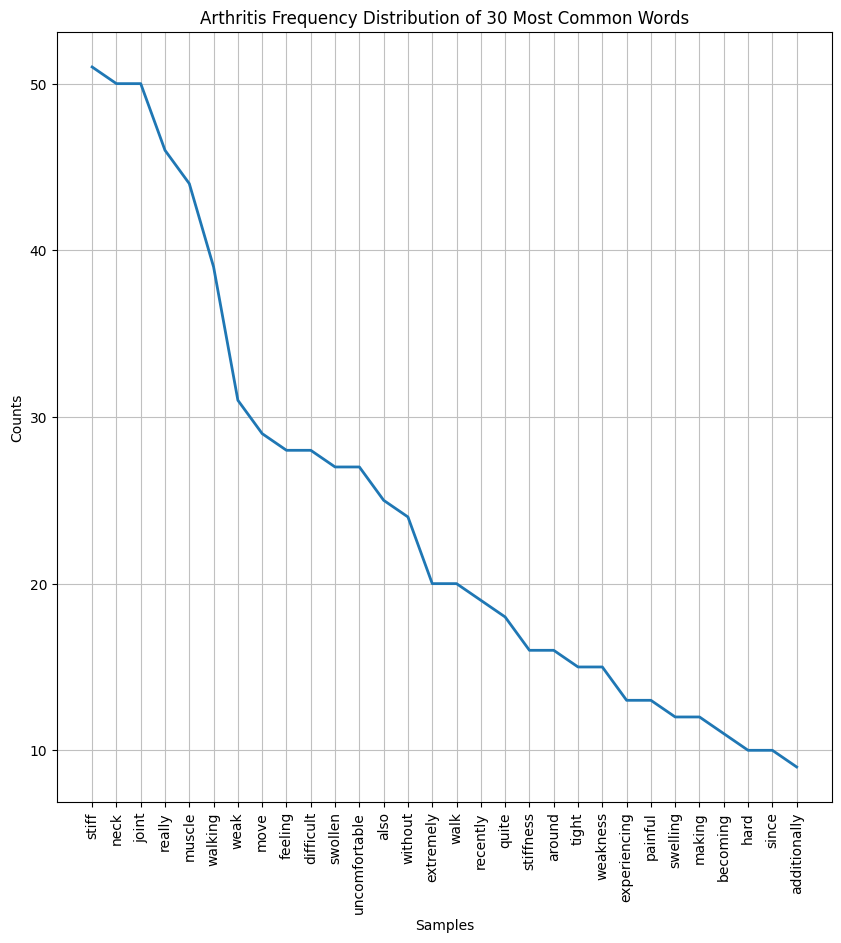

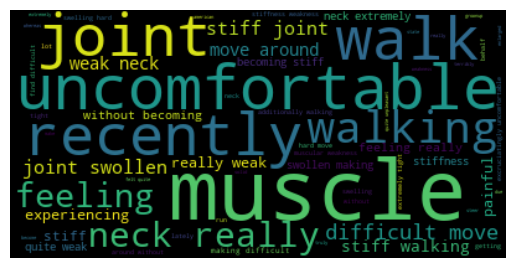

In [10]:
explore_symptoms(df, 'Arthritis', 30)

## Feature Engineering

Feature engineering with these tokens allow machine learning algorithms to be performed on the text data. This process involves **vectorization**, which converts the lists of pre-processed tokens to numerical representation in the corpus. These numerical inputs can serve as features in machine learning classification models that would be performed later.


### train-test-split

Since there are only 50 samples from each disease, the split is completed only once, with 30% being the test set.

In [11]:
# Join all tokens in a row into a string
df['processed_str'] = df['processed'].apply(' '.join)

# Specify x and y for the split
text_data = df['processed_str']
label = df['label']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(text_data, label, test_size=0.3, random_state=42)

### Vectorization

Term Freqeuncy-Inverse Document Frequency **(TF-IDF)** algorithm is used to normalize the raw counts of words in the text data and takes account of importance (how common/rare) of these words across all text.

In [12]:
sw = stopwords.words('english') + ["i've", "i'm"]

# TF-IDF vectorization
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X_train_vec = tf_vec.fit_transform(X_train)
X_test_vec = tf_vec.transform(X_test)

In [13]:
# Convert vectorized features to dataframe
df_X_train_vec = pd.DataFrame(X_train_vec.toarray(), columns=tf_vec.get_feature_names_out())
df_X_test_vec = pd.DataFrame(X_test_vec.toarray(), columns=tf_vec.get_feature_names_out())

## Classification Modeling

Now that the text data have been pre-processed, cleaned, and vectorized, they are ready to be used in machine learning models as features to predict potential diagnosis. Several **classification** models are used, including: **logistic regression**, **multinomial naive bayes**, and **support vector machine** models. **Accuracy** score is used to evaluate these models, indicating how accurately the disease label is classified.

### Model 1: Logistic Regression

In [43]:
# Default logistic regression model
lr = LogisticRegression(random_state=42)
lr.fit(df_X_train_vec, y_train)

print(f"Logistic Regression default model\nTrain set accuracy: {lr.score(df_X_train_vec, y_train)}\nTest set accuracy : {lr.score(df_X_test_vec, y_test)}")


Logistic Regression default model
Train set accuracy: 0.9976190476190476
Test set accuracy : 0.9583333333333334


The default logistic regression model has very high accuracy scores for both train and test sets, with the train set accuracy score slightly higher than the test set accuracy score. This default model uses all default settings. Therefore, `GridSearchCV` is used below to find more optimal hyper-parameters as a fine tuning step.

In [44]:
# Grid search
lr_grid = {
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
    'max_iter': [50, 100, 150]
}

lr_gs = GridSearchCV(estimator=lr, param_grid=lr_grid)
lr_gs.fit(df_X_train_vec, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'max_iter': [50, 100, 150],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']})

In [46]:
# Best parameters from the grid search above
lr_gs.best_params_

{'C': 10, 'max_iter': 50, 'solver': 'newton-cg'}

In [48]:
# Final logistic regression model and accuracy scores
lr_final = LogisticRegression(C=10, max_iter=50, solver='newton-cg', random_state=42)
lr_final.fit(df_X_train_vec, y_train)

print(f"Logistic Regression final model\nTrain set accuracy: {lr_final.score(df_X_train_vec, y_train)}\nTest set accuracy : {lr_final.score(df_X_test_vec, y_test)}")

Logistic Regression final model
Train set accuracy: 1.0
Test set accuracy : 0.975


The final logistic regression model increased both train and test set accuracy scores slightly. However, the train set score is still higher than the test set.

Since the logistic regression model provides coefficients. However, for better interpretability, a custom function is created to calculate the log odds of the coefficients.

In [49]:
def disease_odds(estimator, column_names, disease):
    """
    Calculate log odds of the coefficients from logistic regression model.

    Parameters:
        estimator(estimator): logistic regression model to retrieve coefficients from
        column_names (list): list of relevant column names to generate coefficients
        disease (string): disease label
    Returns:
        odds_coef (dictionary): dictionary with log odds coefficients for the specified disease label
    """
    coef = list(estimator.coef_)
    classes = list(estimator.classes_)
    idx = classes.index(disease)
    dis_coef = coef[idx]

    odds_coef = {}

    for i in range(len(dis_coef)):
        odds_coef[column_names[i]] = np.exp(dis_coef[i])

    return odds_coef

In [50]:
# Get log odds coefficients
disease_odds = disease_odds(lr_final, df_X_train_vec.columns, 'Psoriasis')
disease_odds

{'abdomen': 1.264463151485023,
 'abdominal': 0.7315284027917353,
 'ability': 0.8905086756490281,
 'able': 0.8234798790318669,
 'abound': 0.9365194339919926,
 'absolutely': 0.9224905781667899,
 'aburning': 0.9843639634702707,
 'accomapanied': 0.9565524850555328,
 'accompanied': 1.0518759232793613,
 'ache': 0.6220960771108159,
 'aching': 0.9520499854332719,
 'achy': 0.9776130970848526,
 'acid': 0.857363947423203,
 'acidic': 0.8919980623701401,
 'acidity': 0.9587373104102825,
 'acquire': 0.9783220753205358,
 'acquired': 0.9394166448732281,
 'act': 0.9692051269200155,
 'acting': 0.9452109212279526,
 'activity': 0.8013186030875918,
 'acute': 0.9713545195179732,
 'add': 0.9924993379018467,
 'addition': 0.6317913526358225,
 'additional': 0.9637652875492893,
 'additionally': 0.6760458943258334,
 'admit': 0.9922917286873358,
 'affecting': 0.9548997792889835,
 'afraid': 1.8259608208474172,
 'aftertaste': 0.8081840079736952,
 'aggravated': 0.9574569606895973,
 'agitated': 0.9781790995743717,
 'ag

In [51]:
# Word with highest log odds coefficients
max(disease_odds.items(), key=operator.itemgetter(1))[0]

'nail'

Based on the log odds coefficients from the final logistic regression model, the word **nail** has the highest log odds coefficients, suggesting it is the word most likely to classify the disease label as **psoriasis**. Note that the disease label "psoriasis" only an example, and any other disease label present in the dataset can be used.

### Model 2: Multinomial Naive Bayes

[Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classification model is especially suitable for having discrete features; thus, it is often used in NLP.

In [52]:
# Default multinomial naive bayes model
mnb = MultinomialNB()
mnb.fit(df_X_train_vec, y_train)

print(f"Multinomial Naive Bayse default model\nTrain set accuracy: {mnb.score(df_X_train_vec, y_train)}\nTest set accuracy : {mnb.score(df_X_test_vec, y_test)}")

Multinomial Naive Bayse default model
Train set accuracy: 0.9940476190476191
Test set accuracy : 0.9472222222222222


In [53]:
# Grid Search
mnb_grid = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

mnb_gs = GridSearchCV(estimator=mnb, param_grid=mnb_grid)
mnb_gs.fit(df_X_train_vec, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.0, 0.1, 0.5, 1.0, 2.0],
                         'fit_prior': [True, False]})

In [54]:
mnb_gs.best_params_

{'alpha': 0.1, 'fit_prior': True}

In [55]:
# Final multinomial naive bayes model
mnb_final = MultinomialNB(alpha=0.1)
mnb_final.fit(df_X_train_vec, y_train)

print(f"Multinomial Naive Bayse final model\nTrain set accuracy: {mnb_final.score(df_X_train_vec, y_train)}\nTest set accuracy : {mnb_final.score(df_X_test_vec, y_test)}")

Multinomial Naive Bayse final model
Train set accuracy: 1.0
Test set accuracy : 0.9694444444444444


Overall, the **multinomial naive bayes** model has slightly lower accuracy scores compared to those of the logistic regression. However, the evaluation scores are still very high.

### Model 3: SVM Classifier

[Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html) (SVM) can be also used for classification, and they are notable for their memory efficiency. Since each word present in the text data is serving as a feature, the model is high-dimensional. Therefore, being able to handle high-dimensional features efficiently is very adventageous.

In [56]:
# Default SVC model
svc = SVC(random_state=42)
svc.fit(df_X_train_vec, y_train)

print(f"SVC default model\nTrain set accuracy: {svc.score(df_X_train_vec, y_train)}\nTest set accuracy : {svc.score(df_X_test_vec, y_test)}")

SVC default model
Train set accuracy: 1.0
Test set accuracy : 0.975


In [57]:
# Grid Search for SVC
svc_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf']
}

svc_gs = GridSearchCV(estimator=svc, param_grid=svc_grid)
svc_gs.fit(df_X_train_vec, y_train)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf']})

In [58]:
svc_gs.best_params_

{'C': 10, 'kernel': 'linear'}

In [59]:
# Final SVC model
svc_final = SVC(C=10, kernel='linear', random_state=42)
svc_final.fit(df_X_train_vec, y_train)

print(f"SVC final model\nTrain set accuracy: {svc_final.score(df_X_train_vec, y_train)}\nTest set accuracy : {svc_final.score(df_X_test_vec, y_test)}")

SVC final model
Train set accuracy: 1.0
Test set accuracy : 0.975


The evaluation outcomes are very similar to other two models previously demonstrated. The accuracy scores are very high, although the score from test set is slightly lower than the train set accuracy score.

## Prediction

Since 3 models have been developed to classify disease labels based on the text description of symptoms, a new symptom description is generated by [chatGPT](https://chat.openai.com/) to test the models and make predictions on the diagnosis. The chatGPT is prompted to create a short hypothetical symptom description for the specified disease. I have chosen psoriasis for the sample.

In [61]:
# Function to pre-process, vectorize, and make prediction
def predict_disease(sample, estimator):
    """
    Predict diagnosis from the sample text symptom description with specified estimator
    Parameters:
        sample (string): sample symptom description
        estimator (estimator): specified estimator
    Returns:
        dis_predict (string): predicted disease label
    """
    proc_sample = [' '.join(nlp_preprocessing(sample))]
    proc_sample_vec = pd.DataFrame(tf_vec.transform(proc_sample).toarray(), columns=tf_vec.get_feature_names_out())

    dis_predict = estimator.predict(proc_sample_vec)[0]
    return dis_predict

In [62]:
sample = "I've been dealing with these persistent skin issues for a while. My skin gets all red, scaly, and itchy, especially on my elbows, knees, and scalp. It's not just my skin; my nails have started to change, getting these little dents and turning weird colors. Sometimes, my fingers and toes ache, and it's more painful in the morning or when I've been still for a while. Stress and chilly weather seem to make everything worse. I'm feeling self-conscious about my appearance, and I'm ready to find a solution."

predict_disease(sample, lr_final)

'Psoriasis'

In [63]:
predict_disease(sample, mnb_final)

'Psoriasis'

In [64]:
predict_disease(sample, svc_final)

'Psoriasis'

All 3 models accurately predicted **psoriasis** from chatGPT generated sample symptom description.

## Limitations

There are some limitations to the current dataset, which may influence the performance of the models developed above. Here are some of the limitations to consider:

1. **Limited number of patients**. The current dataset have only 50 patients per disease label. The classification models would have enhanced prediciton power with more symptom descriptions provided.

2. **Limited number of disease labels**. The current dataset have a limited set of diseases. With wider range of diseases that may share similar symptoms, it may present challenges to the models predicting diagnosis.

These limitations may impact the models' performances. Especially because the current dataset are small with limited number of samples of text description, the models may be prone to overfitting.

## Conclusions

### Recommendations

1. Acquire symptom descriptions in text from patients **prior to initial visit**. This can help direct patients to the most appropriate department of hospital, potentially saving time and financial burden.

2. Consistently **update the database** and models with more symptoms descriptions from future patients.

### Future Insights

1. **Consider expanding dataset with more disease labels and more patients**. Not only more patients but also more disease labels can help improve the models.

2. **Consider developing image classification via computer vision**. Although the current project focuses on text-deriven disease prediction, another method to provide initial prediction is via image classification. The image classification via computer vision in conjunction with text-deriven disease prediction models can provide both parties more insights on how to provide efficient treatments.